Data prep and Import Packages

In [1]:
from data_funcs import preprocess, cluster_feature_preprocess
from clustering import number_clusters_vis, kmeans_cluster, cluster_count_vis, cluster_preferences_vis, ks_clustering_test
import pandas as pd


customer_ref = 'data/WSA_data_customer.csv'
data_ref = 'data/WSA_data_order.csv'

# preprocess and data checks
cust_data, order_data = preprocess(customer_ref, data_ref)

# merge data sets
data = pd.merge(cust_data, order_data, on='ACCOUNT_ID', how='left')


In [2]:
# Feature engineering: calculate age, order count, total order amount, etc.
data['age'] = pd.Timestamp.now().year - pd.to_datetime(data['DOB']).dt.year
data['order_count'] = data.groupby('ACCOUNT_ID')['ORDER_ID'].transform('count')
data['avg_order_amount'] = data.groupby('ACCOUNT_ID')['ORDER_AMOUNT'].transform('mean')

# Select relevant features
features = [
    'age', 'BUREAU_SCORE', 'CREDIT_LIMIT_NEW', 'NET_BALANCE', 'FLAG_DUAL_ACCOUNT',
    'REPAYMENT_SCHEDULE_FREQUENCY', 'REPAYMENT_SCHEDULE_AMOUNT',
    'REPAYMENT_ADDITIONAL_AMOUNT', 'ACCT_TOTAL_RPYM_AMT_30D',
    'ACCT_TOTAL_RPYM_CNT_30D', 'ACCT_TOTAL_RPYM_AMT_60D',
    'ACCT_TOTAL_RPYM_CNT_60D', 'CUST_APP_SESSION_L1D', 'CUST_APP_SESSION_L90D',
    'order_count', 'avg_order_amount'
]

# Define target variable
target = 'ENGAGEMENT_SEGMENT'

# Encode the target variable
data[target] = data[target].map({'dormant': 1, 'engaged': 0})


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# Split data into features (X) and target (y)
X = data[features]
y = data[target]

# Identify categorical features
categorical_features = ['REPAYMENT_SCHEDULE_FREQUENCY']
numerical_features = [feature for feature in features if feature not in categorical_features]

# Preprocessing for numerical data
numerical_transformer = StandardScaler()

# Preprocessing for categorical data
categorical_transformer = OneHotEncoder()

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create and train the model within a pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42)) # n estimators = number of trees in forest
]) # default max features to consider for best split = sqrt(n_features) = sqrt(16)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# print("Accuracy:", accuracy)
# print("Confusion Matrix:\n", conf_matrix)
# print("Classification Report:\n", class_report)


                                     Feature  Importance
12                     CUST_APP_SESSION_L90D    0.152902
9                    ACCT_TOTAL_RPYM_AMT_60D    0.143301
13                               order_count    0.122183
14                          avg_order_amount    0.099226
3                                NET_BALANCE    0.092574
10                   ACCT_TOTAL_RPYM_CNT_60D    0.090231
7                    ACCT_TOTAL_RPYM_AMT_30D    0.059087
0                                        age    0.053684
8                    ACCT_TOTAL_RPYM_CNT_30D    0.036008
5                  REPAYMENT_SCHEDULE_AMOUNT    0.032737
1                               BUREAU_SCORE    0.030153
6                REPAYMENT_ADDITIONAL_AMOUNT    0.026438
2                           CREDIT_LIMIT_NEW    0.017494
11                      CUST_APP_SESSION_L1D    0.014880
4                          FLAG_DUAL_ACCOUNT    0.013013
16      REPAYMENT_SCHEDULE_FREQUENCY_Monthly    0.006069
15  REPAYMENT_SCHEDULE_FREQUENC

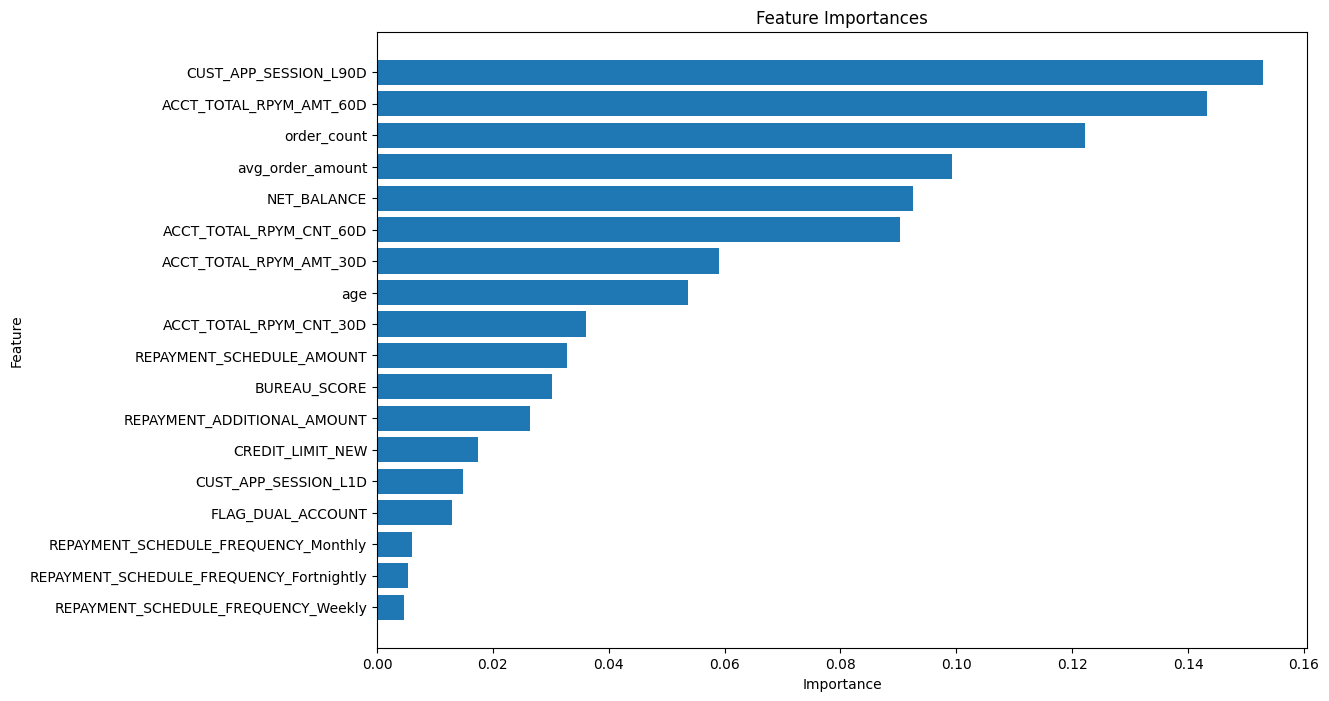

In [4]:
# Extract feature importances from the RandomForest model
importances = model.named_steps['classifier'].feature_importances_
feature_names = numerical_features + list(model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features))

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

# Visualize feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

Shap Plots etc for feature relationships!

Checking overfitting

In [5]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=5)

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean()}")
print(f"Standard Deviation of CV Scores: {cv_scores.std()}")

if cv_scores.std() > 0.05:
    print("Warning: High variance in cross-validation scores. Potential overfitting detected.")


Cross-Validation Scores: [0.94384094 0.9347842  0.93166216 0.93580662 0.93509457]
Mean CV Score: 0.9362376986747114
Standard Deviation of CV Scores: 0.00405832706834977
